In [148]:
# # uncomment this to install packages
# import sys
# !{sys.executable} -m pip install <package name>

### Imports

In [149]:
# imports
import numpy as np
from astropy import units as u
from astropy import coordinates as c
import matplotlib.pyplot as plt
from matplotlib import rcParams as P
import astropy.modeling.rotations as r
from scipy.spatial.transform import Rotation as R
import math
import random

In [150]:
# matplotlib.rcParams.keys()

### Euler Rotation function and other helper functions

In [151]:
def generate_angles():
    # generates the 3 needed euler angles at random
    # angles
    alpha = 2 * np.pi * np.random.random()  #generate random rotation angles
    beta = np.pi * np.random.random()
    gamma = 2 * np.pi * np.random.random()
    
    alpha, beta, gamma = 0.1, 0, 0
    
    return (alpha, beta, gamma)

In [152]:
# This function performs an Euler rotation on the data, returns the new glon and glat
# prof. watkins' code (plus some additions of my own)
# uses scipy to preform a random euler rotation  
def rotate(data, angles, error: float):
    
    # 'angles' tuple must have 3 elements that coorespons to the euler angles of rotation
    alpha, beta, gamma = angles
    
    # data part
    glon = data[: ,10] * np.pi / 180
    glat = data[: ,11] * np.pi / 180

    #make glon and glat into array of positions on the unit sphere
    pos = np.array([np.cos(glon) * np.cos(glat),  # alpha
                np.sin(glon) * np.cos(glat),  # beta
                np.sin(glat)])                # gamma

    pos = np.transpose(pos)

    r = R.from_euler('xzx', [alpha, beta, gamma]) #create the rotation
    posprime = r.apply(pos)  #apply the rotation to the vectors

    glonprime = np.arctan2(posprime[: ,1], posprime[: ,0]) * 180 / np.pi  #convert back to degrees
    glonprime[glonprime < 0] = 360 + glonprime[glonprime < 0]

    glatprime = np.arcsin(posprime[: ,2]) * 180/np.pi
    
    # accounting for zone of avoidance
    indices = np.where(abs(glatprime) > 5)
    glonprime = glonprime[indices]
    glatprime = glatprime[indices]
    
    # adding in error
    glonprime += glonprime*error
    glatprime += glatprime*error
    
    # glonprime, glatprime = c.Angle(glonprime, u.degree), c.Angle(glatprime, u.degree)
    glonprime = c.Angle(glonprime, u.degree)
    glatprime = c.Angle(glatprime, u.degree)
    
    print(f'{alpha=}, {beta=}, {gamma=}')  # angles of rotation (radians)
    glonprime, glatprime = glonprime.wrap_at('180d', inplace=False).radian, glatprime.radian
    
    return glonprime, glatprime

In [153]:
def rotate_bulkflow(bulkflow, angles: tuple, error: float):
    # rotates one bulkflow for ONE catalogue at a time, to be used in a loop in sync with the previous rotate function
    
    # 'angles' tuple must have 3 elements that coorespons to the euler angles of rotation
    alpha, beta, gamma = angles
    
    # rotation part
    r = R.from_euler('xzx', [alpha, beta, gamma])
    bulkflowprime = r.apply(bulkflow)
    
    bulkflowprime += bulkflowprime*error
    
    return bulkflowprime  # returns an array of the new components of the new bulkflow

### Loading, processing, plotting the data

alpha=0.1, beta=0, gamma=0
[ -50.90512942  200.65406292 -193.88890261]
[ -66.64416453  286.7219868  -226.34252076]


C:\Users\yaras\AppData\Local\Temp\ipykernel_20000\1915070821.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


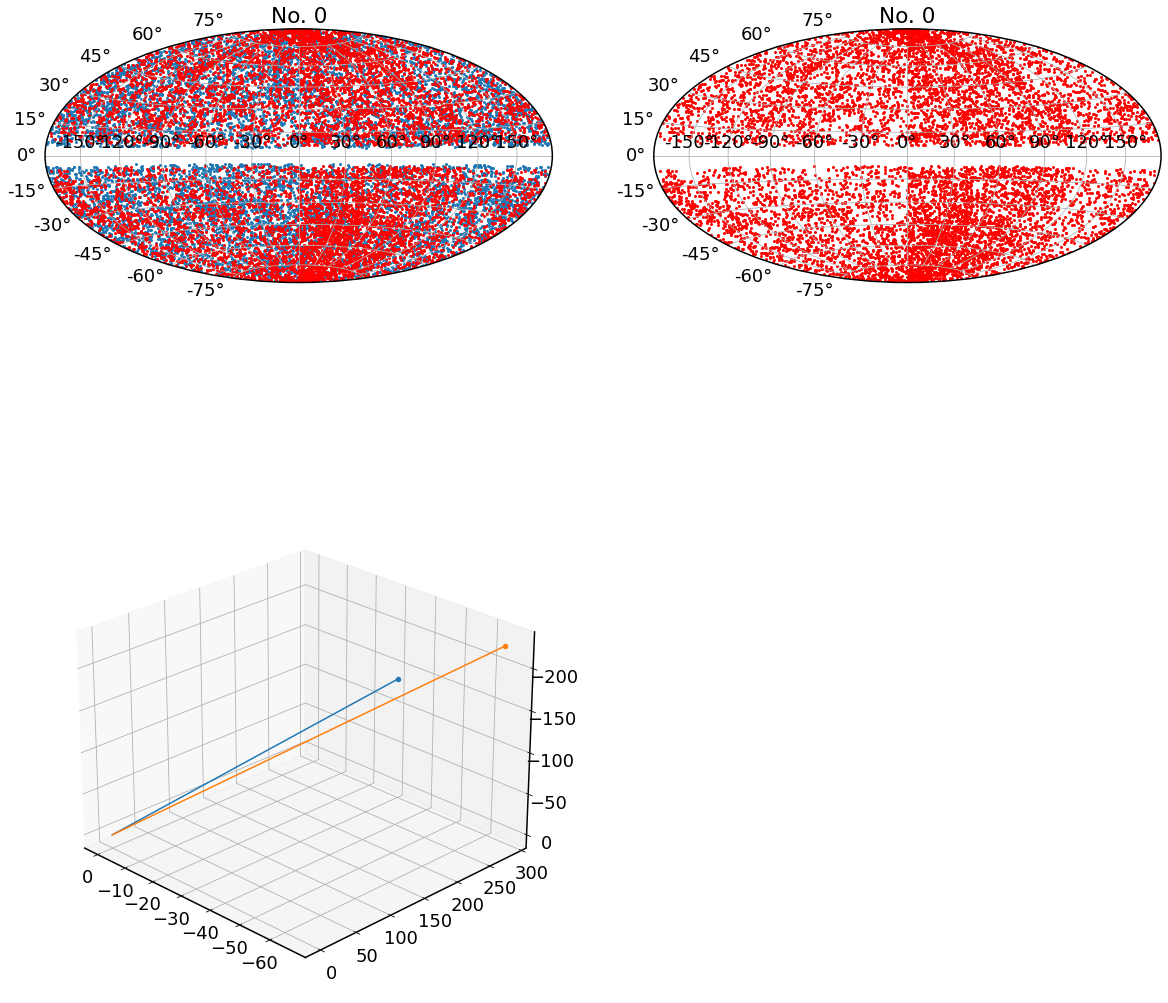

In [154]:
bulkflows = np.load('C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/true_bulkflows100.npy')

# load the data
for i in range(1): # use range(300) to run on all catalogues (BAD IDEA)
    data = np.load(f'C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/CF3-OuterRim-CF3grouplike-cz-rand-box-{i}.npy')
    # glat and glon are in degrees, convert to radians
    glon, glat = data[: ,10], data[: ,11]
    glon = c.Angle(glon, u.degree)
    glat = c.Angle(glat, u.degree)
                    
    # changing range of glon to (-180, 180) instead of (0, 360)
    glon = glon.wrap_at('180d', inplace=False)
    
    # Accounting for zone of avoidance (taking out data points with -5 < glat < 5)
    indices = np.where(abs(glat.value) > 5)
    glon = glon[indices]
    glat = glat[indices]
    # glon, glat = c.Angle(new_coords[0], u.degree), c.Angle(new_coords[1], u.degree)

    # processing the data, rotating it
    angles = generate_angles()
    
    error = np.random.normal() * 0.4
    
    bulkflow = bulkflows[:,i]
    bulkflow_prime = rotate_bulkflow(bulkflow, angles, error)
    
    glonprime, glatprime = rotate(data, angles, error)  # random euler rotation of the data
    
    # making figure
    fig = plt.figure(figsize=(20, 20))
    P.update({'font.size': 18,
                       'axes.linewidth': 1.5,
                       'axes.labelweight': 'bold',
                       })
    
    # subplot 1
    ax1 = fig.add_subplot(221, projection='hammer')
    ax1.scatter(glon.radian, glat.radian, marker='.', linewidths=0.001)
    ax1.scatter(glonprime, glatprime, marker='.', linewidths=0.001, color='red')
    ax1.grid(True)
    ax1.title.set_text(f'No. {i}')
    
    # the angles will be printed
    print(bulkflows[:,i])
    print(bulkflow_prime)
    
    # subplot 2
    ax2 = fig.add_subplot(222, projection='hammer')
    ax2.scatter(glonprime, glatprime, marker='.', linewidths=0.001, color='red')
    
    ax2.grid(True)
    ax2.title.set_text(f'No. {i}')
    fig.show()
    
    x,y,z = bulkflows[:,i]
    x1,y1,z1 = bulkflow_prime
    
    ax = fig.add_subplot(223, projection='3d')
    ax.plot((0, x) ,(0, y),(0, z))
    ax.plot((0, x1) ,(0, y1),(0, z1))
    ax.scatter(x,y,z)
    ax.scatter(x1,y1,z1)
    ax.view_init(-155, 45)

   
  

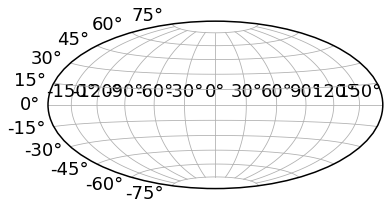

In [155]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='hammer')
# ax.scatter(2*math.pi, math.pi, marker='x', linewidths=2.0)
# ax.scatter(0*math.pi, math.pi/4, marker='x', linewidths=2.0, color='black')
ax.scatter(math.pi, None, marker='x', linewidths=2.0, color='green')
# ax.scatter(math.pi/3, math.pi, marker='x', linewidths=2.0, color='red')
ax.grid(True)